In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import time
import scipy.sparse
import scipy.sparse.linalg

In [53]:
sigma = 1.2 
r = 0.035 
rho = 0.05 

I=500
a_min=-0.05
a_max=3
z_1=0.1
z_2=0.2
z=np.array([z_1,z_2])
lambda_1=1.5
lambda_2=0.5
lambd=np.array([lambda_1,lambda_2])

In [54]:
def u(c):
  return c**(1-sigma)/(1-sigma)

def du(c):
  return c**(-sigma)

def du_inv(u):
  return u**(-1/sigma)

In [55]:
a=np.linspace(a_min,a_max,I)
da=(a_max-a_min)/(I-1)

In [56]:
aa=np.column_stack((a,a))
zz=np.ones((I,2))*z

In [57]:
v=u(zz+r*aa)/rho

# Explicit Scheme

$$\frac{v_{i,j}^{n+1}-v_{i,j}^n}{\Delta}+\rho v_{i,j}^n=u(c_{i,j}^n)+(v_{i,j}^n)'(z_j+ra_i-c_{i,j}^n)+\lambda_j(v_{i,-j}^n-v_{i,j}^n)$$

In [58]:
Delta=0.01

In [59]:
maxit=20000
for n in range(maxit):
  dvf=(v[1:,:]-v[:-1,:])/da
  dvf=np.vstack((dvf,[1,1]))
  dvb=(v[1:,:]-v[:-1,:])/da
  dvb=np.vstack((du(z+a_min),dvb))
  sf=zz+r*aa-du_inv(dvf)
  sb=zz+r*aa-du_inv(dvb)
  sf[-1,:]=-1
  sb[-1,:]=-1
  dv=dvf*(sf>0)+dvb*(sb<0)+(sf<=0)*(0<=sb)*du(zz+r*aa)
  c=du_inv(dv)
  v_new=v+Delta*(u(c)+dv*(zz+r*aa-c)+lambd*(v[:,[1,0]]-v)-rho*v)
  error= np.max(np.abs(v_new-v))
  if error<1e-6:
    print(f'\r {error}',end='')
    break
  v=v_new
  if n%100==0:
    print(f'\r {error}',end='')

 9.999339027899623e-07

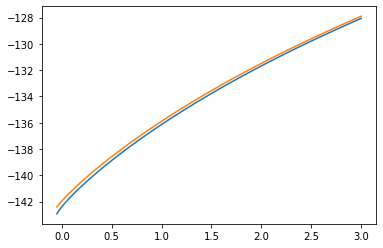

In [60]:
fig,ax=plt.subplots()
ax.plot(aa,v)
fig.show()

# Implicit Scheme

In [61]:
v=u(zz+r*aa)/rho

In [62]:
Delta=1000

In [63]:
maxit=20000
for n in range(maxit):
  dvf=(v[1:,:]-v[:-1,:])/da
  dvf=np.vstack((dvf,[1,1]))
  dvb=(v[1:,:]-v[:-1,:])/da
  dvb=np.vstack((du(z+a_min),dvb))
  sf=zz+r*aa-du_inv(dvf)
  sb=zz+r*aa-du_inv(dvb)

  #sf[-1,:]=-1
  #sb[-1,:]=-1
  dv=dvf*(sf>0)+dvb*(sb<0)+(sf<=0)*(0<=sb)*du(zz+r*aa)-(sb<0)*(sf>0)*du(zz+r*aa)
  dv[-1,:]=dvb[-1,:]
  c=du_inv(dv)

  x_ij=-np.minimum(sb,0)/da
  y_ij=-np.maximum(sf,0)/da+np.minimum(sb,0)/da-lambd
  z_ij=np.maximum(sf,0)/da

  A_11=np.eye(I)*y_ij[:,[0]]+np.eye(I,k=1)*z_ij[:,[0]]+np.eye(I,k=-1)*x_ij[:,[0]]
  A_22=np.eye(I)*y_ij[:,[1]]+np.eye(I,k=1)*z_ij[:,[1]]+np.eye(I,k=-1)*x_ij[:,[1]]
  A_12=np.eye(I)*lambda_1
  A_21=np.eye(I)*lambda_2

  A=np.block([[A_11,A_12],[A_21,A_22]])

  B=(1/Delta+rho)*np.eye(2*I)-A
  b=(u(c)+1/Delta*v).flatten(order='F')

  v_new=np.linalg.solve(B,b)
  error= np.max(np.abs(v_new-v.flatten(order='F')))
  if error<1e-6:
    print(f'\r {error}',end='')
    break
  v=v_new.reshape(-1,2,order='F')
  if n%100==0:
    print(f'\r {error}',end='')

 7.990917083589011e-08

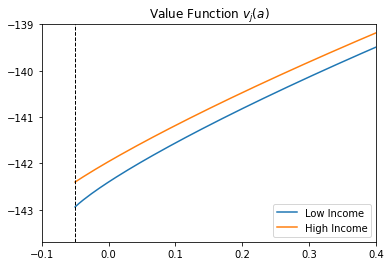

In [109]:
fig,ax=plt.subplots()
ax.plot(aa,v)
ax.axvline(a_min,ls='--',lw=1,c='k')
ax.set(xlim=(a_min-0.05,0.4),
       ylim=(None,-139),
       title=r'Value Function $v_j(a)$')
ax.legend(('Low Income','High Income'))
fig.show()
plt.savefig('fig_1.pdf')

# KFE

In [70]:
g=np.abs(np.linalg.eig(A.T)[1][:,0]).reshape(-1,2,order='F')
g=g/np.sum(g)/da

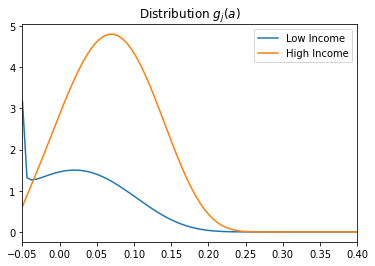

In [110]:
fig,ax=plt.subplots()
ax.plot(aa,g)
ax.set(xlim=(a_min,0.4),
       title=r'Distribution $g_j(a)$')
ax.legend(('Low Income','High Income'))
fig.show()
plt.savefig('fig_2.pdf')

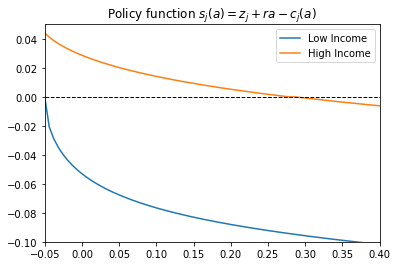

In [111]:
fig,ax=plt.subplots()
ax.plot(aa,zz+r*aa-c)
ax.axhline(0,ls='--',c='k',lw=1)
ax.set(xlim=(a_min,0.4),
       ylim=(-0.1,0.05),
       title='Policy function $s_j(a)=z_j+ra-c_j(a)$')
ax.legend(('Low Income','High Income'))
fig.show()
plt.savefig('fig_3.pdf')

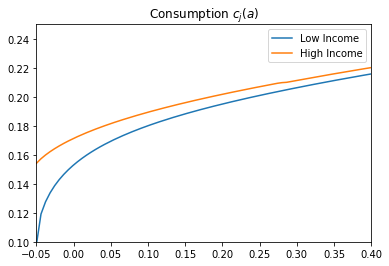

In [112]:
fig,ax=plt.subplots()
ax.plot(aa,c)
ax.axhline(z[0],ls='--',c='k',lw=1)
ax.set(xlim=(a_min,0.4),
       ylim=(0.1,0.25),
       title='Consumption $c_j(a)$')
ax.legend(('Low Income','High Income'))
fig.show()
plt.savefig('fig_4.pdf')

In [88]:
np.sum(aa*g*da)

0.061409202267928176